# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, GlobalAveragePooling2D
from keras.applications import ResNet50, MobileNet
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools


## Downloading the dataset

In [2]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

In [3]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


## Analyzing the dataset

### Creating function to analyze the dataset

In [2]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (256, 256)

In [3]:
cabezera = "category", "image", "real"
df_au = pd.DataFrame(columns=cabezera)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img = cv2.imread(os.path.join(REAL_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    #img_np = np.array(img)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img, 1]], columns=cabezera)], ignore_index=True)

df_au.head()

,category,image,real
0,ani,"[[[226, 185, 76], [222, 180, 73], [221, 180, 7...",1
1,ani,"[[[159, 133, 119], [156, 131, 120], [149, 123,...",1
2,ani,"[[[0, 7, 7], [3, 14, 12], [16, 31, 24], [16, 3...",1
3,ani,"[[[40, 19, 21], [39, 21, 22], [39, 21, 22], [4...",1
4,ani,"[[[79, 21, 9], [80, 22, 10], [81, 22, 10], [83...",1


In [4]:
#remove categoriy txt because it is not in the dataset
df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [5]:
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

Realizaremos el mismo proceso con las imagenes modificadas

In [6]:
cabezera = "category", "image", "region", "real"
key_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec"]
df_tp = pd.DataFrame(columns=cabezera)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img = cv2.imread(os.path.join(FAKE_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    #img_np = np.array(img)
    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img, category[1], 0]], columns=cabezera)], ignore_index=True)

df_tp.head()

,category,image,region,real
0,ani,"[[[197, 173, 153], [197, 173, 153], [199, 175,...",D,0
1,art,"[[[9, 13, 18], [8, 12, 17], [8, 12, 17], [9, 1...",D,0
2,art,"[[[189, 181, 181], [173, 169, 169], [137, 139,...",D,0
3,ani,"[[[48, 78, 59], [65, 95, 76], [65, 91, 78], [6...",D,0
4,ind,"[[[9, 14, 12], [11, 14, 14], [17, 15, 16], [18...",D,0


In [7]:
df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.sample(frac=1).reset_index(drop=True)

In [8]:
def plot_ela_images(original, images: list, qualities: list):
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')
    
    for i, image in enumerate(images):
        fig.add_subplot(1, 4, i+2)
        plt.title("Quality: " + str(qualities[i]))
        plt.imshow(image)
        plt.axis('off')
    plt.show()

def ela(orig_img, quality=90):
    _, buffer = cv2.imencode('.jpg', orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    diff = 15 * cv2.absdiff(orig_img, compressed_img)
    return diff

## Wavelet Analysis

La técnica de wavelet es una herramienta matemática utilizada para el análisis de señales y procesamiento de imágenes. Cuando se aplica a imágenes, la técnica de wavelet descompone la imagen en diferentes escalas y orientaciones, lo que permite identificar patrones y características de la imagen a diferentes niveles de detalle.

Al aplicar la técnica de wavelet a ambas imágenes (la original y la sospechosa), es posible identificar estas diferencias y, por lo tanto, determinar si la imagen ha sido modificada o no. En particular, se pueden comparar los coeficientes de wavelet de las dos imágenes y analizar las diferencias en función de la escala y la orientación.

## Creating Model

### Creating and splitting the dataset

In [9]:
# Preprocesar las imágenes
preprocessed_original = [ela(image) for image in df_au['image']]
preprocessed_manipulated = [ela(image) for image in df_tp['image']]

# Convertir las imágenes a tensores de tensorflow
original_tensors = [tf.convert_to_tensor(image) for image in preprocessed_original]
manipulated_tensors = [tf.convert_to_tensor(image) for image in preprocessed_manipulated]


In [10]:
X = np.array(original_tensors + manipulated_tensors)
Y = np.array([0] * len(original_tensors) + [1] * len(manipulated_tensors))

# Dividir el conjunto de datos en entrenamiento validacion y prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

"""x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)
x_val = x_val.reshape(x_val.shape[0], 256, 256, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 256, 1)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)"""

'x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)\nx_val = x_val.reshape(x_val.shape[0], 256, 256, 1)\nx_test = x_test.reshape(x_test.shape[0], 256, 256, 1)\n\ny_train = to_categorical(y_train)\ny_val = to_categorical(y_val)\ny_test = to_categorical(y_test)'

### Creating the checkpoints

In [11]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


model_chekpoint = ModelCheckpoint(
    filepath='./../model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='./../model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, model_chekpoint, tensor_board]
optimizer = Adam(learning_rate=0.0001)

### Creating the model fron scratch

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation=None, input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Creating the model using transfer learning (ResNet50)

In [15]:
inputs = Input(shape=(256, 256, 1))
convert_to_rgb = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
resized_inputs = Resizing(224, 224)(convert_to_rgb)

model = ResNet50(weights='imagenet', include_top=False, input_tensor=resized_inputs)
for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

### Creating the model using transfer learning (MobileNet)

In [38]:
inputs = Input(shape=(256, 256, 3))
model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

In [21]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar todas las capas del modelo pre-entrenado para que no se modifiquen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales en la parte superior del modelo pre-entrenado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Definir el modelo completo
model = Model(inputs=base_model.inputs, outputs=predictions)

### Training the model

In [39]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50
114/114 [==============================] - 470s 4s/step - loss: 0.3530 - accuracy: 0.8451 - precision: 0.7754 - recall: 0.7602 - auc: 0.9020 - prc: 0.8465 - val_loss: 1.6071 - val_accuracy: 0.3953 - val_precision: 0.3953 - val_recall: 1.0000 - val_auc: 0.6557 - val_prc: 0.5974
Epoch 2/50
114/114 [==============================] - 456s 4s/step - loss: 0.1488 - accuracy: 0.9328 - precision: 0.8872 - recall: 0.9464 - auc: 0.9854 - prc: 0.9759 - val_loss: 0.6210 - val_accuracy: 0.7166 - val_precision: 0.5960 - val_recall: 0.8779 - val_auc: 0.8638 - val_prc: 0.8207
Epoch 3/50
114/114 [==============================] - 457s 4s/step - loss: 0.0807 - accuracy: 0.9672 - precision: 0.9488 - recall: 0.9673 - auc: 0.9961 - prc: 0.9938 - val_loss: 0.2774 - val_accuracy: 0.8882 - val_precision: 0.8111 - val_recall: 0.9348 - val_auc: 0.9582 - val_prc: 0.9273
Epoch 4/50
114/114 [==============================] - 463s 4s/step - loss: 0.0340 - accuracy: 0.9871 - precision: 0.9799 - recall: 0.

### Evaluating the model

In [40]:
model.evaluate(x_test, y_test)

72/72 [==============================] - 32s 449ms/step - loss: 0.5780 - accuracy: 0.8846 - precision: 0.8382 - recall: 0.8606 - auc: 0.9413 - prc: 0.8848


[0.5779975652694702,
 0.8846490979194641,
 0.8382353186607361,
 0.8606271743774414,
 0.9412662982940674,
 0.8848356008529663]

### Showing the results

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def plot_loss_accuracy(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_pred):
    y_pred_binary = np.round(y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Original', 'Manipulated'], rotation=45)
    plt.yticks(tick_marks, ['Original', 'Manipulated'])
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_pred):
    y_pred = model.predict(x_test)

    # Calcular la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    auc_score = auc(*precision_recall_curve(y_true, y_pred)[:2])
    return precision, recall, f1_score, auc_score

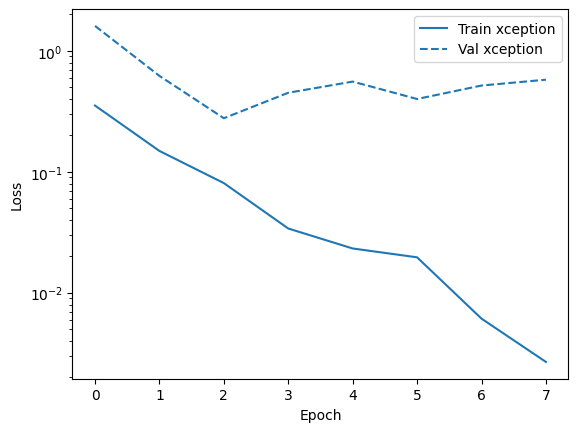

In [42]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, 'xception', 0)

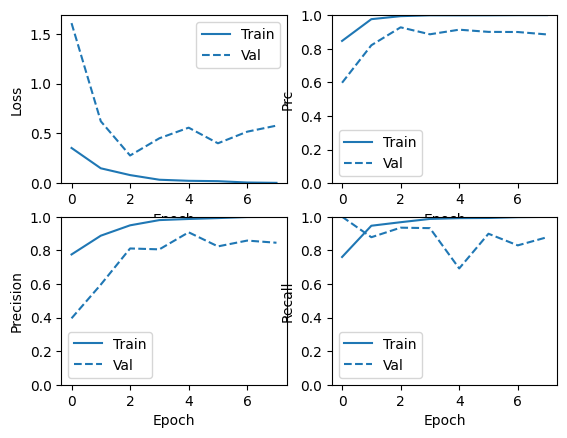

In [43]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [44]:
model.save('./../model/detect_manipulated_images_model_mobileNet_v3.h5')

In [41]:
tf.compat.v1.disable_eager_execution()
model = load_model('./../model/detect_manipulated_images_model_mobileNet_v3.h5')

### Probando modelo con mapa de calor

In [77]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Comprobar si la capa es una capa convolucional
        if isinstance(layer, Conv2D):
            return layer
    
    return None

def predict_with_heatmap(model, img_original):
    # Load image and convert to RGB
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (256, 256))
    img = ela(img_original)
    img = np.expand_dims(img, axis=0)
    
    # Get predictions and last convolutional layer output
    preds = model.predict(img)
    last_conv_layer = get_last_conv_layer(model)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    last_conv_output = last_conv_layer_model.predict(img)
    
    # Get class activation map
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.inputs], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, last_conv_output_value = iterate([img])
    for i in range(last_conv_output_value.shape[-1]):
        last_conv_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(last_conv_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    
    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
    
    return img_original, superimposed_img, class_idx

def plot_heatmap(img_original, superimposed_img, class_idx):
    class_names = ['Manipulated', 'Original']
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(img_original)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Heatmap')
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()
    
    print('Predicted class:', class_idx)
    print('Predicted class name:', class_names[class_idx])

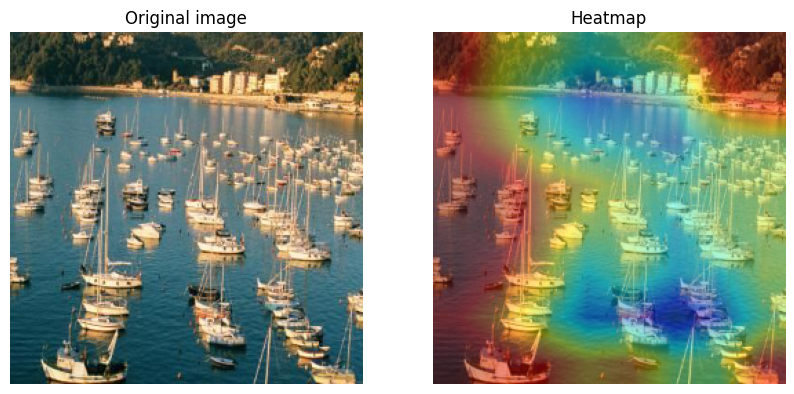

Predicted class: 0
Predicted class name: Manipulated


In [78]:
img = df_tp.iloc[0]['image']
original_img, heatmap_img, result = predict_with_heatmap(model, img)
plot_heatmap(original_img, heatmap_img, result)